<a href="https://colab.research.google.com/github/hyunicecream/Natural-Language-Processing-NLP-/blob/main/7/29_doc2vec_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
 %pip install sentencepiece

     |████████████████████████████████| 1.2 MB 4.1 MB/s 


In [ ]:
# -*- coding: utf-8 -*-
"""6-14.doc2vec_data.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1c0Jn5RsoUlfQuSTR_JQJbF7wbO23PYng
"""

# Commented out IPython magic to ensure Python compatibility.
# %pip install sentencepiece

# Commented out IPython magic to ensure Python compatibility.
import numpy as np
import re
import pickle
from sklearn.datasets import fetch_20newsgroups
import sentencepiece as spm
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

nltk.download('punkt')
# %cd '/content/drive/MyDrive/Colab Notebooks'

# news data를 읽어온다.
newsData = fetch_20newsgroups(shuffle=True, random_state=1, remove=('headers', 'footers', 'quotes'))

news = newsData['data']
topic = newsData['target']

news = [re.sub(r"([.!?\-\n])\1+", "\\1", s) for s in news]   # 연속된 문자를 1개로 바꾼다. (!!!! --> !), (... --> .)
news = [re.sub(r"([\n\t])", " ", s) for s in news]
news = [s.lower() for s in news]


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
N_GRAMS = 10
VOCAB_SIZE = 20000

# news data가 비어있는 경우도 있다. ex : news[11225].
# n-grams word를 구성할 수 없는 경우는 제거한다.
x_data = []
y_topic = []
for doc, top in zip(news, topic):
    words = nltk.word_tokenize(doc)
    if len(words) > N_GRAMS + 2:     # 여유분 2개
        x_data.append(doc)
        y_topic.append(top)

# Sentencepice용 사전을 만들기 위해 데이터를 저장해 둔다.
data_file = "/content/drive/MyDrive/머신러닝/Doc2vec/newsgroup.txt"
with open(data_file, 'w', encoding='utf-8') as f:
    for sent in x_data:
        f.write(sent + '\n')
    

In [ ]:
# Google의 Sentencepiece를 이용해서 vocabulary를 생성한다.
# -----------------------------------------------------
templates= "--input={0:} \
            --pad_id=0 --pad_piece=<PAD>\
            --unk_id=1 --unk_piece=<UNK>\
            --bos_id=2 --bos_piece=<START>\
            --eos_id=3 --eos_piece=<END>\
            --model_prefix={1:} \
            --vocab_size={2:} \
            --character_coverage=0.9995 \
            --model_type=unigram"

model_prefix = "/content/drive/MyDrive/머신러닝/Doc2vec/newsgroup"
params = templates.format(data_file, model_prefix, VOCAB_SIZE)

spm.SentencePieceTrainer.Train(params)
sp = spm.SentencePieceProcessor()
sp.Load(model_prefix + '.model')

with open(model_prefix + '.vocab', encoding='utf-8') as f:
    vocab = [doc.strip().split('\t') for doc in f]

word2idx = {k:v for v, [k, _] in enumerate(vocab)}
idx2word = {v:k for k, v in word2idx.items()}

In [ ]:
# news 문서를 문장 단위로 분해한 후, 문장들을 10-gram 쌍을 만든다.
x_train_pv = []
x_train_w = []
y_train = []

for pvid, doc in enumerate(x_data):
    doc_idx = sp.encode_as_ids(doc)
    for x in nltk.ngrams(doc_idx, N_GRAMS):
        x_train_pv.append(pvid)
        x_train_w.append(list(x[:(N_GRAMS-1)]))
        y_train.append(x[N_GRAMS-1])

x_train_pv = np.array(x_train_pv).reshape(-1, 1)
x_train_w = np.array(x_train_w)
y_train = np.array(y_train).reshape(-1, 1)

x_train_pv.shape, x_train_w.shape, y_train.shape


((3620482, 1), (3620482, 9), (3620482, 1))

In [ ]:
[idx2word[i] for i in x_train_w[0]]

['▁well', '▁i', "'", 'm', '▁not', '▁sure', '▁about', '▁the', '▁story']

ok


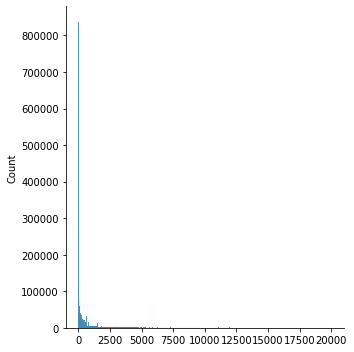

In [ ]:
# 데이터 개수를 확인한다.
if len(set(x_train_pv[:, 0])) == len(x_data):
    print('ok')

sns.displot(y_train.reshape(-1))

In [ ]:
# Subsampling of frequent words. down sampling only.
# [1]의 후속 논문인 [2]에 소개된 subsampling 기법을 적용한다.
def sub_sampling(x, y, z):
    # x, y를 합친다.
    data = np.hstack([x, y, z])
    
    # data = (x, y, z) 쌍을 shuffling 한다.
    np.random.shuffle(data)
    
    # data의 z 값을 기준으로 subsampling을 적용한다.
    d_sample = np.empty(shape = (0, N_GRAMS+1), dtype=np.int32)
    for z_set in set(data[:, N_GRAMS]):
        z_tmp = data[np.where(data[:, N_GRAMS] == z_set)]

        fw = 1e-8 + z_tmp.shape[0] / data.shape[0]
        pw = np.sqrt(1e-5 / fw)              # 남겨야할 비율
        cw = np.int(z_tmp.shape[0] * pw) + 1 # 남겨야할 개수 - subsampling 개수
        d_sample = np.vstack([d_sample, z_tmp[:cw]])

    # 짧은 문서인 경우는 문서 전체가 빠질 수 있다.
    # 문서 전체가 빠진 경우를 학습 데이터에 추가한다.
    unseen_id = list(set(data[:,0]) - set(d_sample[:, 0]))
    for i in unseen_id:
        idx = np.where(data[:, 0] == i)
        d_sample = np.vstack([d_sample, data[idx]])
    
    # 다시 한번 shuffle 한다.
    np.random.shuffle(d_sample)

    r_pv = d_sample[:, 0].reshape(-1,1)
    r_seq = d_sample[:, 1:N_GRAMS]
    r_tg = d_sample[:, N_GRAMS].reshape(-1,1)

    return r_pv, r_seq, r_tg


In [ ]:
x_pv, x_seq, y_tg = sub_sampling(x_train_pv, x_train_w, y_train)
x_pv.shape, x_seq.shape, y_tg.shape

((772630, 1), (772630, 9), (772630, 1))

In [ ]:
if len(x_data) == len(set(x_pv[:, 0])):
    print('ok')
else:
    print('nok')

# sampling 데이터를 저장한다.
with open('/content/drive/MyDrive/머신러닝/Doc2vec/pv_dm_data.pkl', 'wb') as f:
    pickle.dump([x_data, x_pv, x_seq, y_tg, y_topic], f, pickle.DEFAULT_PROTOCOL)

ok


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
